#Colab compatible code


In [1]:
!pip install monai
!pip install itk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 61.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Ilias-Paralikas/diplomatikh_outputs.git
netG_Path = 'diplomatikh_outputs/netG.pt'
netD_Path = 'diplomatikh_outputs/netD.pt'
trail_counter_PATH = 'diplomatikh_outputs/trial_counter.txt'

Cloning into 'diplomatikh_outputs'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 74 (delta 8), reused 17 (delta 5), pack-reused 51
Receiving objects: 100% (74/74), 121.30 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (47/47), done.


In [3]:
f = open("diplomatikh_outputs/demofile2.txt", "a")
f.write("Now the file has more content!")
f.close()

#open and read the file after the appending:
f = open("diplomatikh_outputs/demofile2.txt", "r")
print(f.read()) 

Now the file has more content!


#imports

In [4]:
import os
from monai.transforms import LoadImage,Orientation
import torchvision.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import itk
import torch.optim as optim
from glob import glob
import torchvision.utils as vutils
# import nrrd
from torch.utils.data import Dataset
import random


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tensorflow13

In [5]:
ngpu  = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#Image preprocessing

In [6]:
class ImagePreprocessor():
    def __init__(self,
                 img_dir='data/Acrin_data',
                 mask_dir = 'data/resampled_masks'):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.file_numbers =[]
        for img in os.listdir(self.img_dir):
          img_num  =  "".join([ele for ele in img if ele.isdigit()])
          self.file_numbers.append(img_num)


    # def health_check(self):
    #   assert len(self.img_names) ==len(self.mask_names)
    #   for i in range(len(self.img_names)):
    #     img_num  = "".join([ele for ele in self.img_names[i] if ele.isdigit()])
    #     mask_num  = "".join([ele for ele in  self.mask_names[i] if ele.isdigit()])
    #     assert img_num==mask_num
    #     img_name = os.path.join(self.img_dir,self.img_names[i])
    #     img = LoadImage(image_only=True,ensure_channel_first=True, simple_keys=True)(img_name)
    #     img_shape = img.shape
    #     mask_name= os.path.join(self.mask_dir,self.mask_names[i])
    #     mask = nrrd.read(mask_name)
    #     mask_shape =mask[0].shape
    #     assert img_shape[1:] == mask_shape
    #     print(mask_shape)

    def get_img_filename(self,idx):
      return os.path.join(self.img_dir,'patient'+str(idx)+'.nii.gz')
    def get_mask_filename(self,idx):
      return os.path.join(self.mask_dir,'segmentation'+str(idx)+'.nrrd')



    def get_min_slices(self):
      self.mask_coordinates = {}
      min_size_scan = 1000
      max_non_zeromask_length =0
      for file_number in self.file_numbers:
        mask_file = self.get_mask_filename(file_number)
        #mask  =nrrd.read(mask_file)[0]
        mask = LoadImage(reader="itkreader")(mask_file)[0]
        min_size_scan = min(min_size_scan,mask.shape[2])
        coordinate = [-1,-1]
        for i in range(mask.shape[2]):
            if np.any(mask[:,:,i] !=0):
                if coordinate[0]==-1:
                    coordinate[0]= i
                coordinate[1]=i

        self.mask_coordinates[str(file_number)] = coordinate
        max_non_zeromask_length = max((coordinate[1]-coordinate[0]+1),max_non_zeromask_length)


      self.slices_size = min(max_non_zeromask_length,min_size_scan)

    def slice_images(self,
                    sliced_data_dir='sliced_data',
                    percent_offset=0.3):
      if not os.path.exists(sliced_data_dir):
        os.mkdir(sliced_data_dir)

      self.get_min_slices()

      for i in self.file_numbers:
        img_file = self.get_img_filename(i)
        mask_file = self.get_mask_filename(i)
        # mask  =nrrd.read(mask_file)[0]
        mask = LoadImage(reader="itkreader")(mask_file)[0]
        img = LoadImage(image_only=True)(img_file)
        while self.mask_coordinates[i][1] - self.mask_coordinates[i][0] > self.slices_size:
          self.mask_coordinates[i][0]  +=1
          self.mask_coordinates[i][1]  -=1



        slices_start_max = min(self.mask_coordinates[i][0],  mask.shape[2]  -self.slices_size)
        slices_start_min = max(self.mask_coordinates[i][1] - self.slices_size,0)
        # print('slices_start_min: ',slices_start_min)
        # print('slices_start_max: ',slices_start_max)
        start =random.randint(slices_start_min,slices_start_max)
        # print("mask dimension : ", mask.shape[2])
        # print(self.mask_coordinates[i])
        # # print(start)
        # print('#####################')
        mask =  Orientation(axcodes='RAS')(mask)
        mask = T.Resize(64)(mask)
        mask = mask.permute(2,0,1)
        total_offset = int(percent_offset  * mask.shape[2])
        mask = mask[:,:,total_offset:]

        img =  Orientation(axcodes='RAS')(img)
        img = T.Resize(64)(img)
        img = img.permute(2,0,1)
        total_offset = int(percent_offset  * img.shape[2])
        img = img[:,:,total_offset:]
        #img = T.Normalize((torch.mean(img)),(torch.max(img)))(img)
        #danger

        patient = torch.stack((img,mask))
        filename = os.path.join(sliced_data_dir,'patient'+str(i) +'.pt')
        torch.save(patient,filename)

# Preprocessor = ImagePreprocessor()
# Preprocessor.slice_images()

#dataloader

In [7]:
class MyDataLoader(Dataset):
    def __init__(self,
                 sliced_data_dir='/kaggle/input/sliceddata/sliced_data',
                 dimensions = 128,
                 transforms = None,
                 remake_folder=False):
        self.dimensions = dimensions
        self.resized_folder  = 'sliced_'+str(dimensions)
        if not os.path.isdir(self.resized_folder):
          os.mkdir(self.resized_folder)
          remake_folder =True
        if remake_folder:
          for filename in os.listdir(sliced_data_dir):
            file_path = os.path.join(sliced_data_dir,filename)
            patient=torch.load(file_path)
            patient = T.Resize((dimensions,dimensions))(patient)
            normalised = self.min_max_norm(patient[0])
            patient = torch.stack((normalised,patient[1]))
            resized_file_path = os.path.join(self.resized_folder,filename)
            torch.save(patient,resized_file_path)
        self.filenames = [os.path.join(self.resized_folder,f) for f in os.listdir(self.resized_folder)]
        self.len = len(self.filenames)
        self.transforms = transforms

    def __len__(self):
        return self.len

    def __getitem__(self,idx):
        if self.transforms:
          patient =  torch.load(self.filenames[idx])
          patient = self.transform(patient)
          return patient,1
        return torch.load(self.filenames[idx]),1

    def visualize(self,idx=0,outsider=None):
      if outsider ==None:
          patient = self.__getitem__(idx)[0]
      else:
          patient = outsider
      medical_img =  patient[0]
      mask = patient[1]
      mask = torch.ceil(mask)
      masked = np.ma.masked_where(mask == 0, mask)

      w = 30
      h = 30
      fig = plt.figure(figsize=(20, 20))
      columns = 8
      rows = 8
      for i in range(0, columns*rows):
          img = medical_img[i,:,:]
          fig.add_subplot(rows, columns, i+1)
          plt.imshow(img, cmap='gray')
          plt.imshow(masked[i,:,:],'prism', interpolation='none', alpha=1)
      plt.show()

    def min_max_norm(self,t):
      return (t - torch.max(t) )/ (torch.min(t) -  torch.max(t))

dataset = MyDataLoader(remake_folder=True)


The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


In [8]:
os.getcwd()

'/kaggle/working'

In [9]:
dataset.filenames[1]

'sliced_128/patient115.pt'

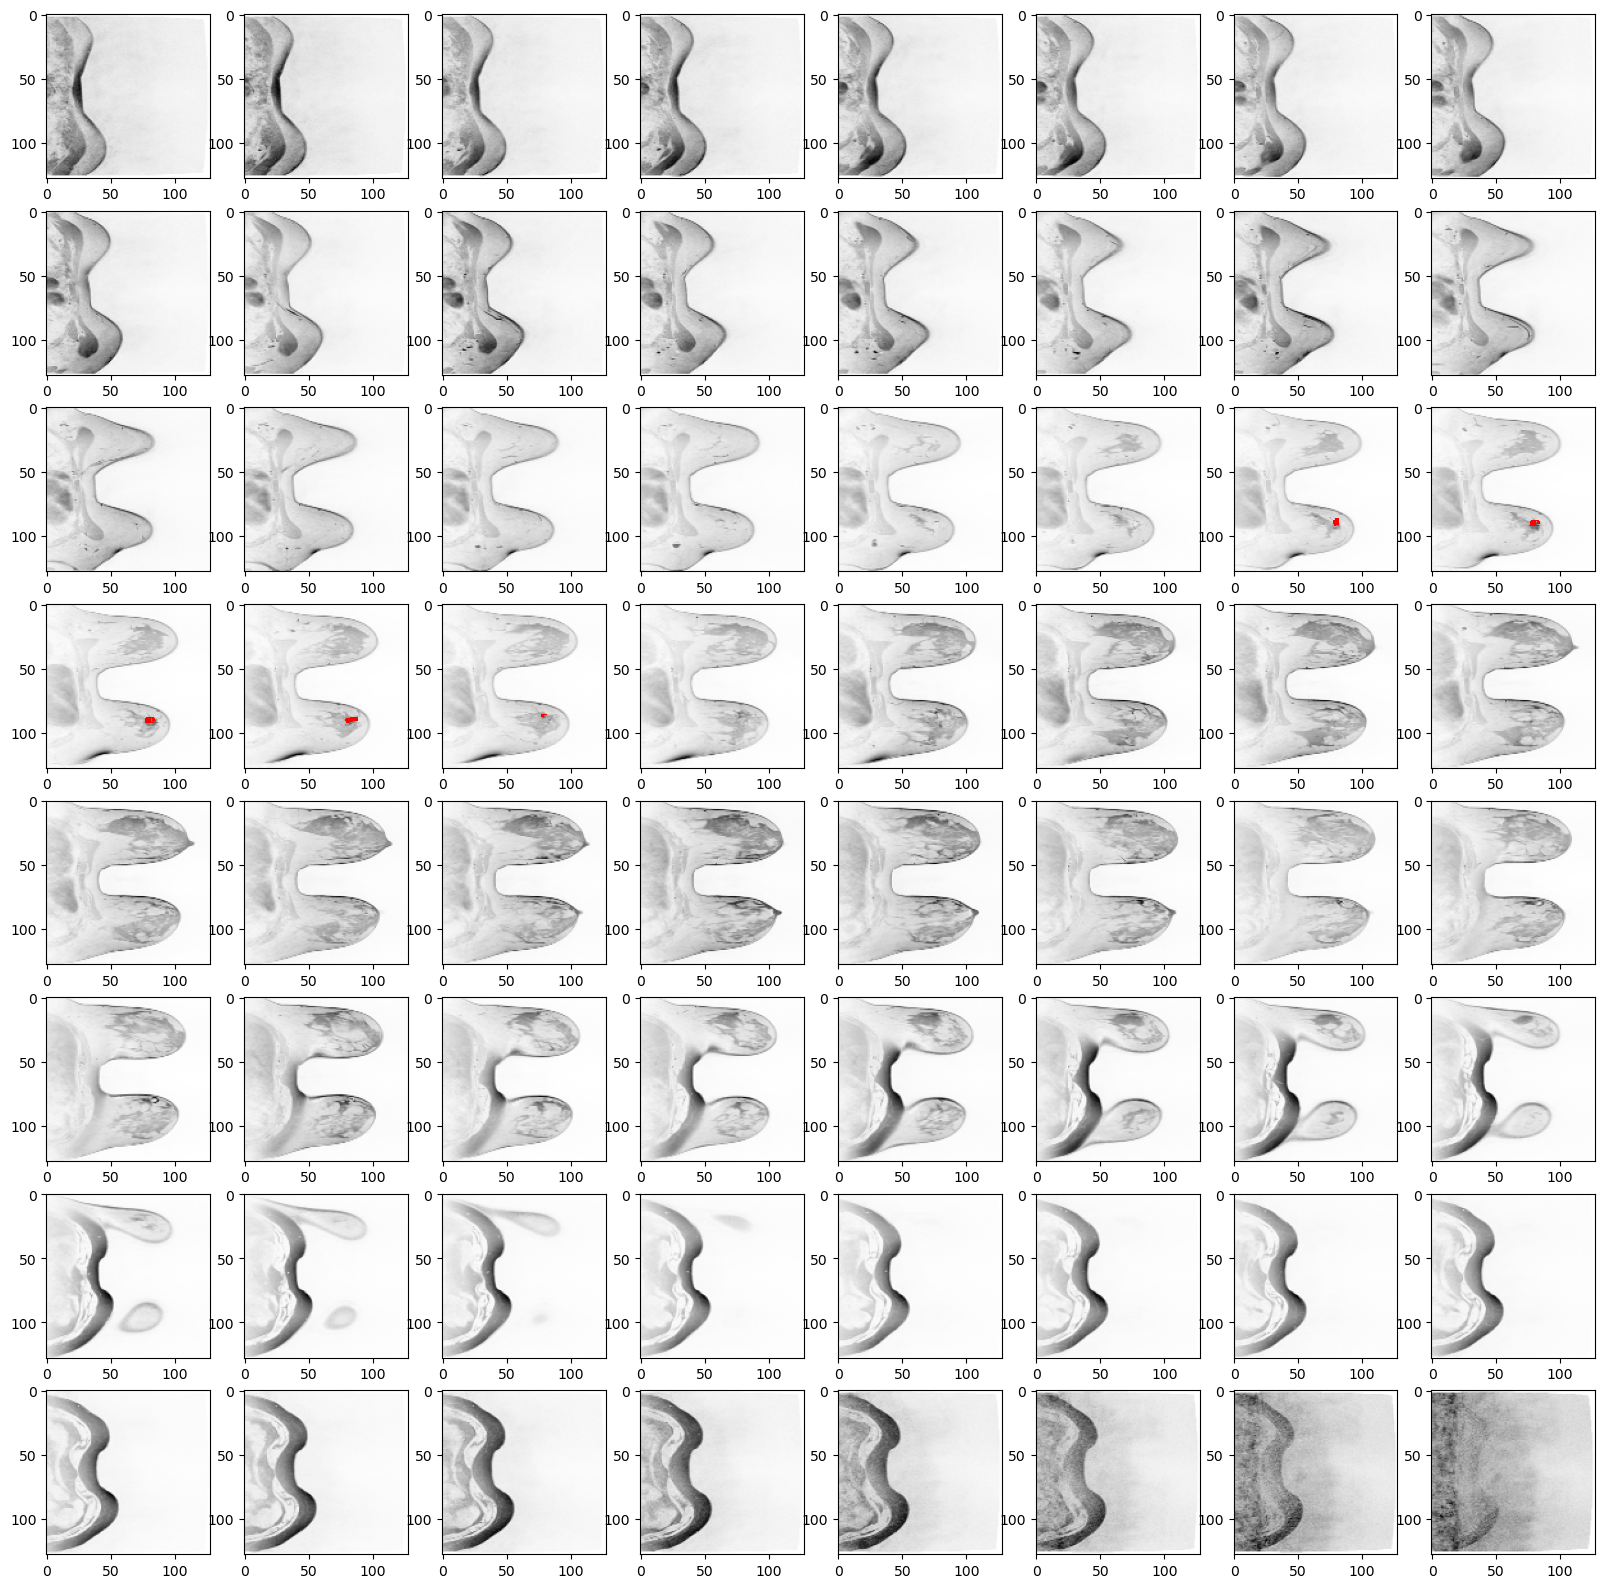

In [10]:
dataset.visualize(1)

In [11]:
workers =2
batch_size =2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [12]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#generator

In [13]:
# Generator Code
nz =100

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
                  nn.ConvTranspose3d( 128,64, 4, 1, 0, bias=False),
                  nn.BatchNorm3d(64),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.ConvTranspose3d( 64,32, 4, 2, 1, bias=False),
                  nn.BatchNorm3d(32),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.ConvTranspose3d( 32,16, 4, 2, 1, bias=False),
                  nn.BatchNorm3d(16),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.ConvTranspose3d( 16,8,  4, 2, 1, bias=False),
                  nn.BatchNorm3d(8),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.ConvTranspose3d( 8,  4, 4, 2, 1, bias=False),
                  nn.BatchNorm3d(4),
                  nn.LeakyReLU(0.2, inplace=True),
                  nn.ConvTranspose3d( 4,  2,(1,4,4), (1,2,2), (0,1,1), bias=False),
                  nn.Tanh()

)

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
if os.path.isfile(netG_Path):
    netG.load_state_dict(torch.load(netG_Path))
    print('read netG')
else:
    netG.apply(weights_init)
# Print the model
print(netG)

read netG
Generator(
  (main): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose3d(16, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, i

In [15]:
noise = torch.rand(1,128,1,1,1)
fake =netG(noise)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 noise = torch.rand(1,128,1,1,1)                                                              │
│ ❱ 2 fake =netG(noise)                                                                            │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ in forward:30                                                                                    │
│                                                                                                  │
│   27 )                                                                                           │
│   28 │                                                                                           │
│   29 │   def forward(self, input):                                                               │
│ ❱ 30 │   │   return self.main(input)                                                             │
│   31                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_

#discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv3d( 2,  4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 4,  8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 8,  16, 4, 2, 1, bias=False),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 16,  32, 4, 2, 1, bias=False),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 32,  64, 4, 2, 1, bias=False),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 64,  128, 4, 2, 1, bias=False),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d( 128,  1, (1,4,4), (1,2,2), (0,1,1), bias=False),


            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator

netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
if os.path.isfile(netD_Path):
    netD.load_state_dict(torch.load(netD_Path))
    print('read netD')
else:
    netD.apply(weights_init)


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise =  torch.rand(1,128,1,1,1)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
lr = 0.001
beta1 =0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop...")
# For each epoch
num_epochs =20000
for epoch in range(num_epochs):
    # For each batch in the dataloader
    if epoch%10 ==0:
        f = open(trail_counter_PATH, "r")
        trial = int(f.read())
        f.close()
        trial = trial+1
        f = open(trail_counter_PATH, "w")
        f.write(str(trial))
        f.close()

        print('saving model')
        torch.save(netD.state_dict(), netD_Path)
        torch.save(netG.state_dict(), netG_Path)
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.rand(b_size,128,1,1,1)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

In [ ]:
k = netG(fixed_noise)[0].cpu()
k = k.detach()

In [ ]:
dataset.visualize(outsider=k)